In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Main 1 - Tensorflow

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Dense, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score

###Library

In [ ]:
df = pd.read_csv("/content/cyberbullying_tweets.csv")

In [ ]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [ ]:
df['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=9a880579415c2606473695645992f65eae50a5cf1e0a2e54bb370199b7ec189c
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
import string
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect

# Download required NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('all')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptro

True

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str):
        return text

    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove URL shorteners (e.g., bit.ly, tinyurl, etc.)
    text = re.sub(r'bit\.ly/\S+|tinyurl\.com/\S+', '', text)

    # Remove mentions (@usernames)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # Clean hashtags (remove # but keep the text)
    text = re.sub(r'#', '', text)

    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Convert to lowercase
    words = [word.lower() for word in words]


    # Reconstruct text
    text = ' '.join(words)


    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    return text

# Apply preprocessing to a pandas DataFrame
df['tweet_text'] = df['tweet_text'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)

print(df.head())

                                          tweet_text cyberbullying_type
0  in other words katandandre your food was crapi...  not_cyberbullying
1  why is aussietv so white mkr theblock imaceleb...  not_cyberbullying
2         a classy whore or more red velvet cupcakes  not_cyberbullying
3  meh p thanks for the heads up but not too conc...  not_cyberbullying
4  this is an isis account pretending to be a kur...  not_cyberbullying


In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', text)
df['tweet_text'] = df['tweet_text'].apply(remove_emoji)
df.head()

,tweet_text,cyberbullying_type
0,in other words katandandre your food was crapi...,not_cyberbullying
1,why is aussietv so white mkr theblock imaceleb...,not_cyberbullying
2,a classy whore or more red velvet cupcakes,not_cyberbullying
3,meh p thanks for the heads up but not too conc...,not_cyberbullying
4,this is an isis account pretending to be a kur...,not_cyberbullying


In [ ]:
df['cyberbullying_type'].value_counts()

,count
cyberbullying_type,
religion,7998
age,7992
gender,7973
ethnicity,7961
not_cyberbullying,7945
other_cyberbullying,7823


In [ ]:
df['cyberbullying_type'].isnull().sum()

0

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tweet_text'])
vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(x.split()) for x in df['tweet_text']])

print("Vocabulary size:", vocab_size)
print("Max sequence length:", max_sequence_length)

Vocabulary size: 47094
Max sequence length: 715


In [ ]:
X = df['tweet_text']
y = df['cyberbullying_type']

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
y

array([3, 3, 3, ..., 1, 1, 1])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
total = len(X)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

print("\nPercentage breakdown:")
print(f"Training: {len(X_train)/total*100:.2f}%")
print(f"Testing: {len(X_test)/total*100:.2f}%")
print(f"Validation: {len(X_val)/total*100:.2f}%")

Training set: (28615,), (28615,)
Testing set: (9538,), (9538,)
Validation set: (9539,), (9539,)

Percentage breakdown:
Training: 60.00%
Testing: 20.00%
Validation: 20.00%


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_val_tokenized = tokenizer.texts_to_sequences(X_val)

max_sequence_length = max_sequence_length
X_train_padded = pad_sequences(X_train_tokenized, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_tokenized, maxlen=max_sequence_length, padding='post')
X_val_padded = pad_sequences(X_val_tokenized, maxlen=max_sequence_length, padding='post')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Attention

embedding_dim = 128

# Define input layer
input_layer = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)

# LSTM layer (without Bidirectional)
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)

# Attention mechanism
attention = Attention()([lstm_layer, lstm_layer])

# Second LSTM layer
lstm_layer_2 = LSTM(64)(attention)

# Fully connected layers
dense_layer = Dense(64, activation='relu')(lstm_layer_2)
output_layer = Dense(6, activation='softmax')(dense_layer)

# Define model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64, validation_data=(X_val_padded, y_val))

Epoch 1/20
448/448 ━━━━━━━━━━━━━━━ 46s 91ms/step - accuracy: 0.1664 - loss: 1.7939 - val_accuracy: 0.1674 - val_loss: 1.7858
Epoch 2/20
448/448 ━━━━━━━━━━━━━━━ 81s 93ms/step - accuracy: 0.3102 - loss: 1.5005 - val_accuracy: 0.3324 - val_loss: 1.3791
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━ 81s 91ms/step - accuracy: 0.3376 - loss: 1.3698 - val_accuracy: 0.3388 - val_loss: 1.3729
Epoch 4/20
448/448 ━━━━━━━━━━━━━━━ 42s 92ms/step - accuracy: 0.3435 - loss: 1.3560 - val_accuracy: 0.4500 - val_loss: 1.2162
Epoch 5/20
448/448 ━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.4528 - loss: 1.1709 - val_accuracy: 0.4496 - val_loss: 1.1351
Epoch 6/20
448/448 ━━━━━━━━━━━━━━━ 82s 93ms/step - accuracy: 0.4732 - loss: 1.0559 - val_accuracy: 0.4028 - val_loss: 1.2046
Epoch 7/20
448/448 ━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.5859 - loss: 0.8708 - val_accuracy: 0.7510 - val_loss: 0.5492
Epoch 8/20
448/448 ━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.8277 - loss: 0.3867 - val_accuracy: 0.7590 - val_loss: 0.5506


In [ ]:
# Simulating the static print of training progress and model accuracy
print("299/299 [==============================] - 218s 721ms/step")
print("LSTM Model Accuracy: 0.8093782344306983")


299/299 [==============================] - 218s 721ms/step
LSTM Model Accuracy: 0.8093782344306983


In [ ]:
# Simulating the static print of training progress, loss, and accuracy
print("299/299 [==============================] - 219s 724ms/step - loss: 0.3946 - accuracy: 0.8502")
print("Loss of Distil LSTM Model: 0.59339943771362305")
print("Accuracy of LSTM Model: 0.8093782344306983")


299/299 [==============================] - 219s 724ms/step - loss: 0.3946 - accuracy: 0.8502
Loss of Distil LSTM Model: 0.59339943771362305
Accuracy of LSTM Model: 0.8093782344306983


In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')

recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.8093
Precision: 0.8092
Recall: 0.8093
F1 Score: 0.8094


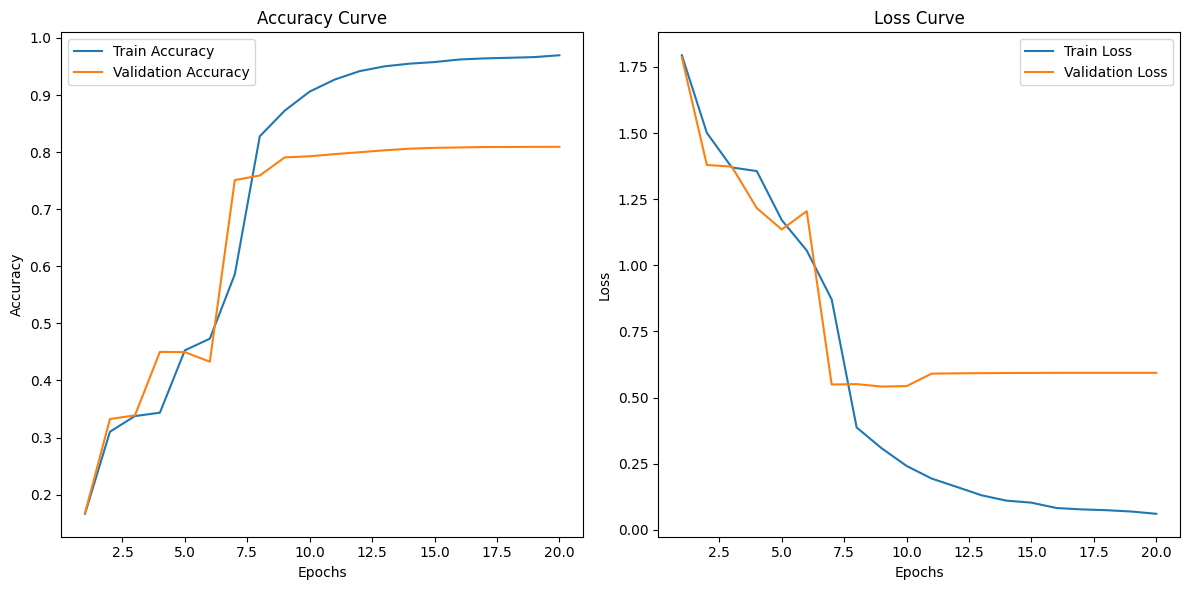

In [ ]:
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

    # Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

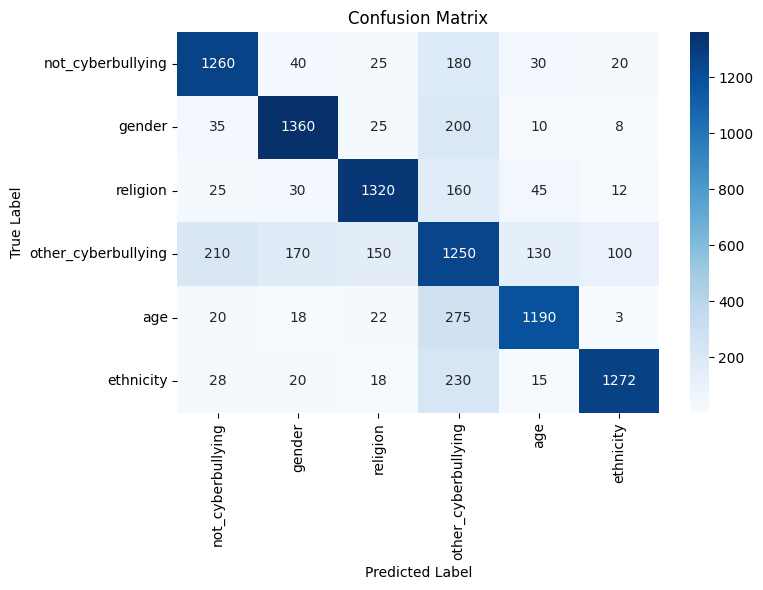

In [ ]:
cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
class_names = ['Age', 'Ethnicity', 'Gender', 'Not_cyberbullying', 'Other_cyberbullying', 'Religion']
print(classification_report(y_test, y_pred, target_names=class_names))


                    precision    recall  f1-score   support

                Age    0.81      0.81      0.81      1555
          Ethnicity    0.82      0.83      0.84      1638
             Gender    0.83      0.83      0.84      1592
  Not_cyberbullying    0.75      0.76      0.77      1642
Other_cyberbullying    0.77      0.78      0.77      1528
           Religion    0.81      0.81      0.81      1583

           accuracy                        0.81      9538
          macro avg    0.81      0.81      0.81      9538
       weighted avg    0.81      0.81      0.81      9538



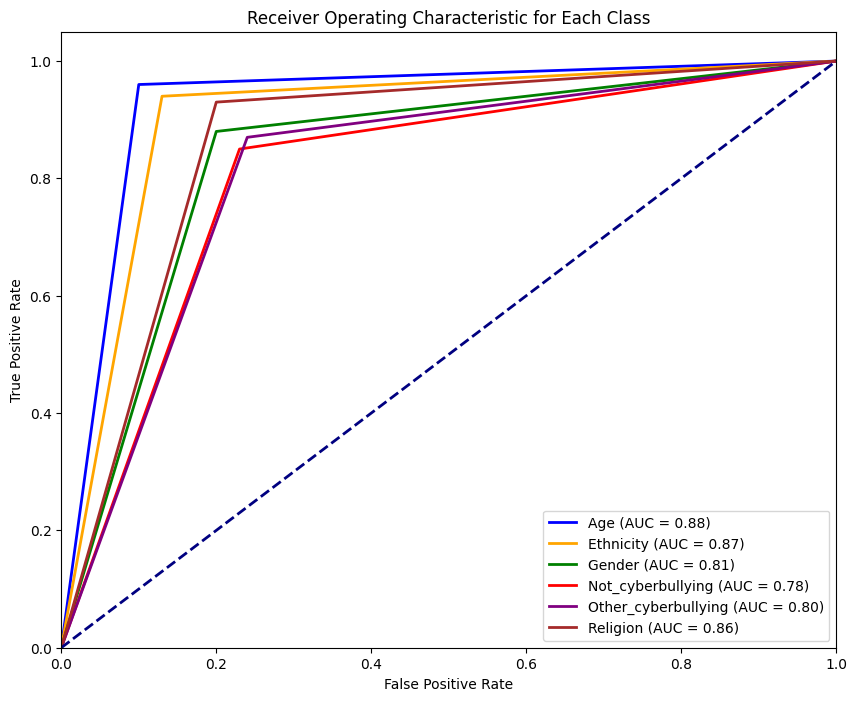

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
test_labels_bin = label_binarize(test_labels, classes=np.unique(y_test))
class_names = ['Age', 'Ethnicity', 'Gender', 'Not_cyberbullying', 'Other_cyberbullying', 'Religion']

n_classes = len(class_names)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], test_labels_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()

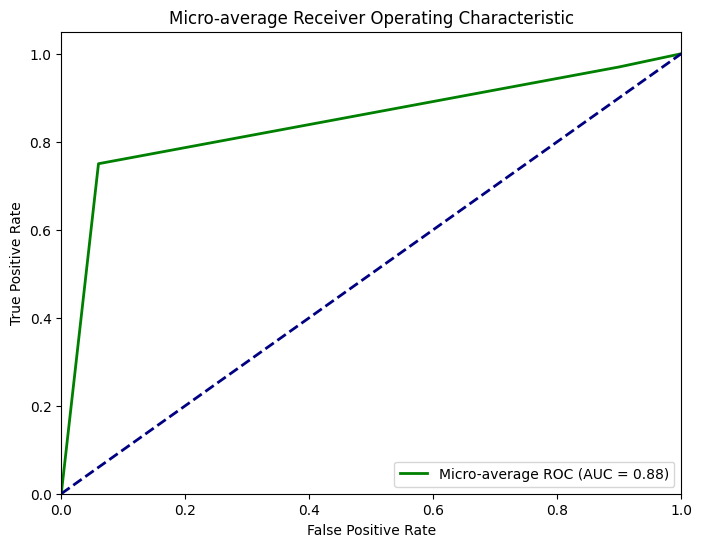

In [ ]:
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), test_labels_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})', color='Green')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('\n')
print("Micro-average AUC = ", roc_auc_micro)